<a href="https://colab.research.google.com/github/AK18k/ex2_1/blob/main/ex2_latenight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/AK18k/ex2_1

Cloning into 'ex2_1'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), 1.90 MiB | 2.71 MiB/s, done.


In [3]:
import os
from google.colab import drive
#drive.mount('/content/drive')
DATA_PATH = '/content/ex2_1/data/ptb'
PATH = '/content/ex2_1'
os.chdir('/content/ex2_1')
!ls

data  ex2_latenight.ipynb  main.ipynb  README.md


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


In [5]:
import os
import torch

from collections import Counter


class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids


In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Result_Matrix:
    def __init__(self, model_type):
      self.model_name = model_type
      self.nepochs = 0
      self.train_ppl = np.array([])
      self.val_ppl = np.array([])
      self.test_ppl = np.array([])

    def add_result(self, result, result_type = 'train'):
      if result_type == 'train':
        self.train_ppl = np.append(self.train_ppl, result)
      elif result_type == 'val':
        self.val_ppl = np.append(self.val_ppl, result)
      elif result_type == 'test':
        self.test_ppl = np.append(self.test_ppl, result)

    def get_results(self, result_type = 'train'):
      if result_type == 'train':
        return(self.train_ppl)
      elif result_type == 'val':
        return(self.val_ppl)
      elif result_type == 'test':
        return(self.test_ppl) 


def plot_results(result_matrix):
  plt.figure()
  y = result_matrix.get_results('train')
  plt.plot(np.arange(1,len(y)+1), y, label = 'train', color = 'blue')
  y = result_matrix.get_results('val')
  plt.plot(np.arange(1,len(y)+1), y, label = 'val', color = 'green')
  y = result_matrix.get_results('test')
  plt.plot(np.arange(1,len(y)+1), y, label = 'test', color = 'red')
  plt.legend()
  plt.title(f'Model Type = {result_matrix.model_name}')
  #plt.ylim((0.75, 1))
  plt.xlabel('eoch')
  plt.ylabel('perplexity')
  plt.grid()
  plt.show()  


tensor([ 0,  1,  2,  ..., 39, 26, 24])
train_data shape = torch.Size([929589])
inputs_counter = 1
inputs = tensor([  35, 6174,   42, 1043,   48,   26,   64, 7359,   32, 4225,   64,  109,
        6535,   24,   35, 1511,  189, 5780, 4225,  289, 4078,  256,   34, 8481,
          26,   93,  159,  188,   87,   32, 2787,  990,   35, 5612])
inputs shape = torch.Size([20, 34])


<ipython-input-16-1a0b34b606b6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


inputs_counter = 2
inputs = tensor([3150,   42,   27, 2603, 7868, 1466, 4260,  852,   24, 6008, 2896, 3116,
         416,   27,  468,   42,  536,   50,  823, 1997,  503,   42,   27, 2603,
        3582, 1466, 4260,  852,   24, 6576, 2281,  510, 1068,  416])
inputs shape = torch.Size([20, 34])
inputs_counter = 3
inputs = tensor([ 603,  570,  103, 5479, 5480,   24,   32,  101, 4358,   40,  840, 1134,
        1402, 1624,   48,   32, 1884, 1624,  119,  200, 3153,   30, 4511,  118,
          24,   32, 1884, 1624,  432,  414,   42,  133,  416,   27])
inputs shape = torch.Size([20, 34])
inputs_counter = 4
inputs = tensor([ 216, 3576,  639,  795,  119, 2235,  145,   40,   32,  295,   42,   26,
          24,  566,  895,   93,  495,  159, 1162,  136,  315,   93,  556,  486,
         159, 1162, 2442, 2915,   24, 6836, 9734, 1886,   69, 7027])
inputs shape = torch.Size([20, 34])
inputs_counter = 5
inputs = tensor([2491,   26,   24,   32, 9577, 1515,  396,  775,  220, 4206,   24,  141,
          40,

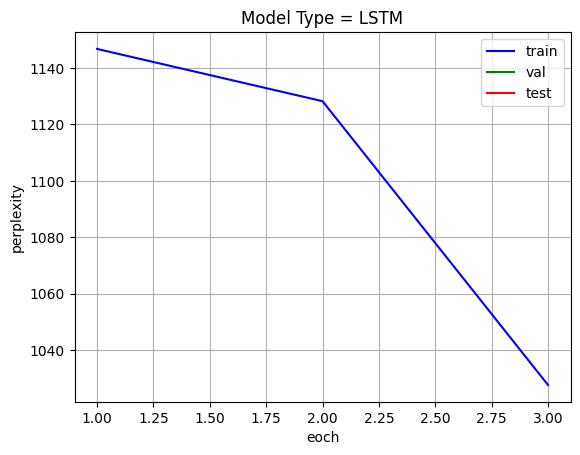

In [16]:


# First, let's define a custom Dataset to read the vectors of words
class PTBDataset(Dataset):
    def __init__(self, data_, sequence_length_=35):
        # In practice, `data` should be a list of integers representing the words in the PTB data set.
        # self.data = [torch.tensor(item, dtype=torch.long) for item in data]
        self.data = data_
        self.sequence_length = sequence_length_
  
    def __len__(self):
        return len(self.data) // self.sequence_length
   
    def __getitem__(self, idx):
        x = self.data[idx * self.sequence_length: (idx + 1) * self.sequence_length]
        x = torch.tensor(x)
        return x

# Collate function to pad sequences in the same batch to the same length
def collate(batch):
    return pad_sequence(batch, batch_first=True)

# Create a DataLoader
corpus = Corpus('data/ptb')
train_data = corpus.train  
data = train_data
print(data)
dataset = PTBDataset(data)
dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=True)

# Now let's define the LSTM language model
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, nlayers = 2, dout = 0):
        super(LanguageModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dout)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x)
        x, _ = self.lstm(x)
        x = self.linear(x)

        return x

# Create the model
vocab_size = len(corpus.dictionary)  # replace with your actual vocabulary size
embedding_dim = 300
hidden_dim = 512
model = LanguageModel(vocab_size, embedding_dim, hidden_dim)

# Define a loss function
loss_function = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
print(f'train_data shape = {train_data.shape}')
results_m = Result_Matrix('LSTM') 
for epoch in range(3):  # replace 10 with the number of epochs you want to train
    inputs_counter = 0
    for inputs in dataloader:        
        targets = inputs[:, 1:].contiguous()
        inputs = inputs[:, :-1].contiguous()

        inputs_counter = inputs_counter + 1
        print(f'inputs_counter = {inputs_counter}')
        print(f'inputs = {inputs[0]}')
        print(f'inputs shape = {inputs.shape}')

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.size(-1))

        targets = targets.view(-1)
       
        loss = loss_function(outputs, targets)
       
        # Calculate perplexity
        perplexity = torch.exp(loss)
              
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if 20 < inputs_counter:
          break
    
    results_m.add_result(perplexity.detach().numpy(), 'train')  
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Perplexity: {perplexity.item()}")

plot_results(results_m)

In [7]:
print(type(data))

<class 'torch.Tensor'>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
